[Table of Contents](./table_of_contents.ipynb)

#  g-h 滤波

In [8]:
from __future__ import division, print_function
%matplotlib inline

In [9]:
#format the book
import book_format
book_format.set_style()

## 思想实验

想象一下我们生活在一个没有称（用于测量体重的设备）的世界。 一天一个同事跑过来找到你，宣称她发明了一个叫做称的设备。 经过她的讲解之后，你迫不及待站了上去，**172 磅**。你很激动，人生中第一次你知道了自己的体重。更重要的是你看到了商机，可以通过卖这个玩意儿实现财富自由了！

另一个同事听到了骚动声跑过来。你解释了一下这个叫称的玩意儿，然后站上去，骄傲的公布 **161 磅**。这时你犹豫了，困惑了，蒙了。

"刚才还是 **172 磅**", 你开始向你的同事抱怨。

"我又没说我的称很准"

传感器是有误差的。 这正是大量滤波研究的初衷所在，也是本书要解决的问题。我将展示半个多世纪来我们的研究工作者是怎么解决这个问题的。在我们展开对应的数学知识之前，我们继续我们称的故事，希望借此能帮助我们能直观理解所谓的滤波。

**另一个称**

有办法改进我们的称重结果么？很明显，换个好点儿的称是个好主意。不幸的是你同事说她就做了10个称，并且所有的称质量大差不离。于是她又拿来一个称，现在你有两个称。于是你称了两次体重，称 (A) 显示 160 磅, 称 (B) 显示 170 磅。 那你究竟体重几何呢？

好吧，现在怎么办?

* 信任称 A, 将 160磅作为我们的体重估计值
* 信任称 B, 将 170磅作为我们的体重估计值
* 选一个比160小的数
* 选一个比170大的数
* 选一个介于160和170之间的数

前两个方案貌似可信，可我们选择其中一个的理由是什么呢，凭什么厚此薄彼呢？接下来的两个简直不可理喻了，称是不准，但我们此刻没有任何根据选择一个“法外之数”。现在只剩下最后一个选择，这也是唯一合理的选择。如果两个称都不准，结果要么高点儿，要么低儿，那么真相往往就在两者之间。 

在数学上有一个概念叫 [*期望值*](https://en.wikipedia.org/wiki/Expected_value), 稍后讲解。
> 在概率论和统计学中，数学期望(mean)（或均值，亦简称期望）是试验中每次可能结果的概率乘以其结果的总和，是最基本的数学特征之一。它反映随机变量平均取值的大小。
需要注意的是，期望值并不一定等同于常识中的“期望”——“期望值”也许与每一个结果都不相等。期望值是该变量输出值的平均数。期望值并不一定包含于变量的输出值集合里。
大数定律规定，随着重复次数接近无穷大，数值的算术平均值几乎肯定地收敛于期望值. (引用自 百度百科)

 想象一下，如果我们称近百万次呢？有时，两个称都称低了，有时都称高了，但大多数时候会是一个高一个低。当结果一高一低时，我们当然要选一个介于两个读数之间的值。可如果是都称高了或者都称低了呢？我们是否还是要选一个介于两者之间的数呢？例如，我们的实际重量是180磅，160磅将是一个很大的误差。可我们选择一个介于160与170之间的数，我们的这个估计至少比160好。当两个称都称高的时候也一样。稍后，我们将用更高级的方法处理这个问题，现在我们将称A和称B的均值作为我们的最优估计，

$$\frac{160+170}{2} = 165$$

我们通过图来更直观的看看这个问题，假设两个称的误差都是8磅。测量结果在160与170之间，所以体重也就介于两个数值之间。 

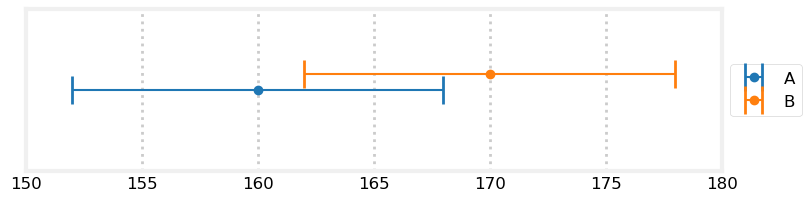

In [10]:
import kf_book.book_plots as book_plots
from kf_book.book_plots import plot_errorbars
plot_errorbars([(160, 8, 'A'), (170, 8, 'B')], xlims=(150, 180))


所以165磅是个合理的估计，可是我们有更多的信息可以应用。可能的体重结果理论上只能出现在两条线的交集内。例如，161磅是一个不可能的估计，因为称B的读数为170，称最多有8的误差，那么真实的体重是不会小于162的。同样，考虑到称A的结果和误差，169也不是一个可能的估计。所以，上边的例子中体重的可能区间被缩小到162-168.

然后呢？这个信息并没有让我们的估计结果有什么提高，继续玩我们的思想实验。如果称A比称B质量好呢？假设A的最大误差是3，B的最大误差是9.在此种情况下，似乎我们有更多的理由选则A作为我们的估计，毕竟A的精度更高。B能提高我们的精度么？

答案是肯定的。假设我们的测量结果依然是A=160 B=170.

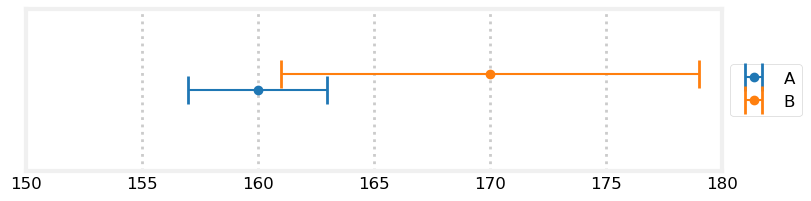

In [11]:
plot_errorbars([(160, 3, 'A'), (170, 9, 'B')], xlims=(150, 180))

真实的体重只可能存在于两条线的重叠部分。可以看到，这个重叠部分的范围要比只使用A的情况要小。更重要的是这个结果不包含160和165。如果我们因为A的精度高而只用A的话，我们给出的估计将会是160.如果我们按照之前的方法进行平均那么我们给出的估计是165.考虑到精度信息的话，这两个值都是不可能的！所以，考虑到精度信息的话，我们的估计值的范围应在161-163之间。

继续我们的思想实验。假设A的最大误差是1.换句话说，如果我们的体重是170，那么A称得的结果只能是169，170，171. B的最大误差依然是9.现在我们用两个称称一下体重，A=160,B=170. 那我们的体重估计是多少呢？且看下图。

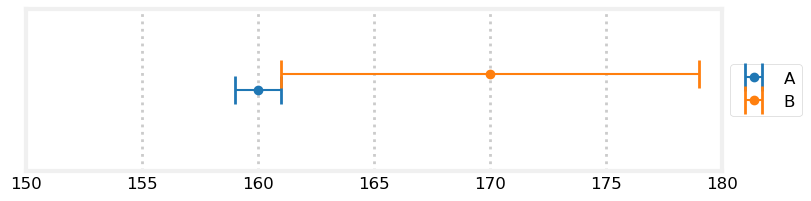

In [12]:
plot_errorbars([(160, 1, 'A'), (170, 9, 'B')], xlims=(150, 180))

我们可以看到，唯一可能的结果是161.多么令人欣喜。用两个相对不准确的传感器我们竟然得到了真值！

**两个传感器总比一个好，即便一个比另一个精度差也是如此。** 在本书中我会反复强调这个观点。我们不丢弃让你和数据，哪怕精度再差也一样。我们会开发相应的算法来融合所有来源的数据，从而得到最优估计。

且慢,我们扯远了。没有人会愿意买一大堆称，并且同事已经说了，所有的称质量都半斤八两——精度是一样的。

如果我只买一个称，然后称很多次呢？上边我们说了，有两个同等精度的称时，我们会将结果平均。那如果我用同一个称称10,000次呢？不难证明，对大量测量数据的平均会非常接近真值，下面我们做个仿真实验。

In [13]:
import numpy as np
measurements = np.random.uniform(160, 170, size=10000)
mean = measurements.mean()
print('量测均值为 {:.4f}'.format(mean))

量测均值为 164.9982


上述仿真输出的结果取决于随机数生成器，但无论如何这个结果会很接近165.

上述代码做了一个假设。对于165的真实重量，测量结果是160和165的可能是一样的。而实际情况通常不是如此。实际传感器的输出在真值附近的可能性要大，离真值越远，可能性就越小。在后边高斯分布的章节会讲这个问题。现在，使用函数`numpy.random.normal()`生成真值为165的高斯分布，这个函数生成的随机数更加像一个真实传感器的输出。

In [14]:
mean = np.random.normal(165, 5, size=10000).mean()
print('量测均值为 {:.4f}'.format(mean))

量测均值为 165.0071


结果依然接近165.

好吧，我们找到了一个称重问题的解决方案！等等～。谁会有这个耐心称体重的时候上上下下上万次呢，恐怕十次都难。

继续我们的思想实验。如果是每天称一次呢？结果是170，161，169.这说明什么？体重在涨，在减，还是这些只是称的误差的影响，实际上你的体重一直没变。

鬼知道。从170到169，貌似少了1磅。但如果称的最大误差是10，那么说少的这1磅是称的误差引起的，也完全说的通。或许第一天的真实体重是165，第三天的真实体重是172，实际是在增肥，这也有可能啊。所以，体重称貌似说明我们在减肥，说不定我们体重正在嗖嗖上涨！看下边的图更加直观。

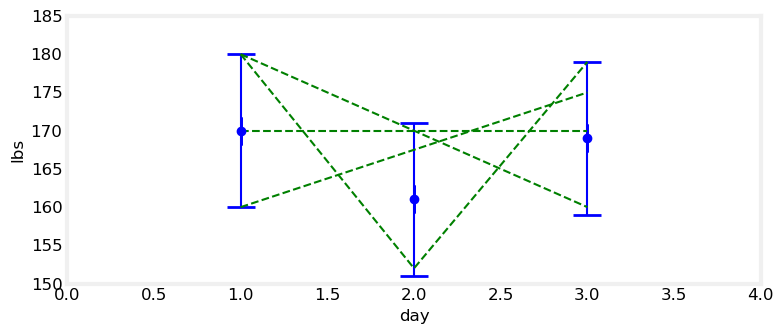

In [15]:
import kf_book.gh_internal as gh
gh.plot_hypothesis1()

看吧，绿线就是可能的体重走势。理论上，有无数种可能。放弃么？不是我性格！我们必须意识到我们讨论的是测量一个人的体重。**正常情况下**，人的体重不可能第一天180到了第三天突然变成160.也不可能一天之内掉肉30磅，下一天又涨回来了。

我们对量测结果的解读，应该符合被测物体本身的固有特性。例如，我们测量的是一块石头每天的重量，那么测量结果的变化理论上都是噪声引起的。如果我们有一个蓄水池（接的雨水）供应我们的家庭用水，我们对它的水位进行测量，那这种测量结果的变化更多的反应的是实际水位的变化。

假设我又换了个称，每天称一下，结果是： 169, 170, 169, 171, 170, 171, 169, 170, 169, 170.直觉是？或许你每天都涨了1磅，可是在噪声的影响下，看起来你的体重一直保持不变。或许，你每天都减了1磅，也有可能得到这样的结果。真的会么？仍十次硬币，都是正面朝上的概率多大？微乎其微。所以通过这组数据比较合理的推断是，你的体重基本保持不变。直观结果看下图，绿色虚线为趋势线。真实体重变化可能与趋势线不同，但这至少是一个合理的解释。

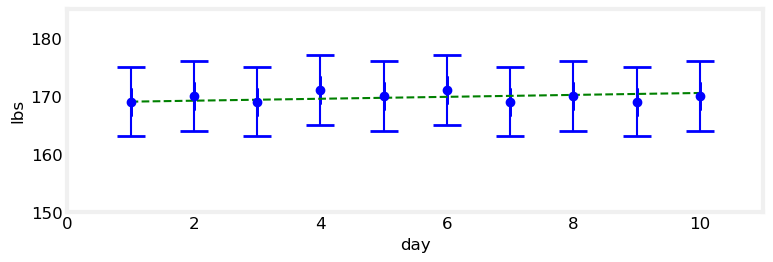

In [16]:
gh.plot_hypothesis2()

继续我们的思想实验，如果读数是 158.0, 164.2, 160.3, 159.9, 162.1, 164.6, 169.6, 167.4, 166.4, 171.0? 先看图，再思考几个问题。

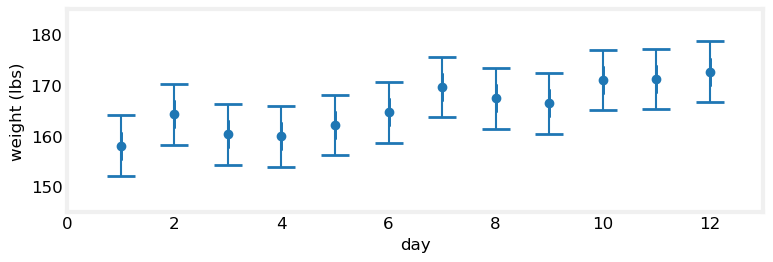

In [17]:
gh.plot_hypothesis3()

我体重下降了，这些波动都是测量噪声引起的？不像。我体重没变？也不像。曲线变化的趋势是上升的，虽然不均匀，但肯定是上升的。虽然我们没法百分百确定，但是从曲线看来我在明显的增重。我们通过画图来验证这个假设。看图要比看表简单多了。

我们来做两个假设。首先，假设我体重没变。那么我将所有数据平均来估计我的真实体重，看下图。


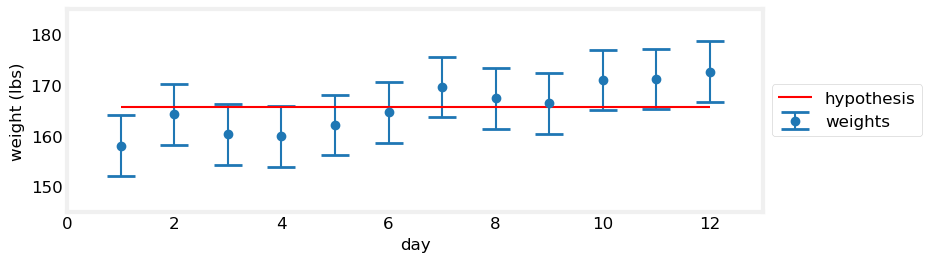

In [18]:
gh.plot_hypothesis4()

完全没有说服力，我们设置无法画一条线，使其穿过所有的蓝色区间。

现在假设我在增重，增了多少？不知道，但是Numpy可以。NumPy的`polyfit()`可以根据最小二乘拟合画一条红线。我们暂且不要过度关注于这个函数本身，用就是了。

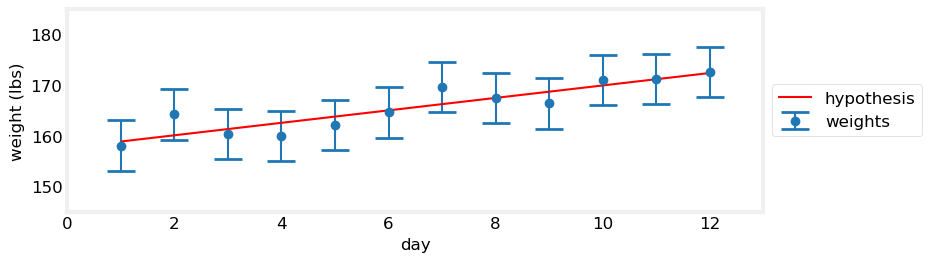

In [19]:
gh.plot_hypothesis5()

这个看起来顺眼多了。可以看到这个假设离每个观测都很近，而在上一个假设中，有的地方已经跑出了观测的误差范围。所以，我在增重的可能比保持不变的可能要大很多。然而，我真的涨了13磅么？鬼知道。这看起来很难回到。

“不可能知道么？” 同事问道。

来点儿疯狂的点子。假设我每天涨1磅。别问我怎么知道的，假设这个假设大致准确。或许我每天摄入足够多的卡路里，或许我有其他增重方式，总之我大约每天涨1磅。这是一个思想实验，不必拘泥小节。那这个假设有什么用呢？

第一个测量值是158.我们就把这个值作为第一次的估计值（第一次也没有其他值可用）。如果我们今天重158，明天呢？我们既然已经知道每天涨1磅，明显我们预计明天将会是159，如下图：

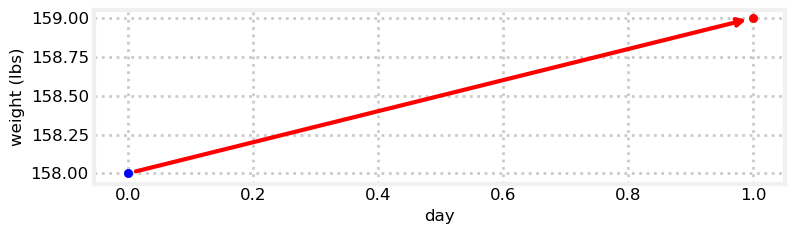

In [20]:
gh.plot_estimate_chart_1()

但是，这么假设有什么好处呢？当然有好处，现在我们可以预计以后10天的体重了。那么问题又来了，现在要称干什么？别急，继续实验，我走上体重称，164.2磅。

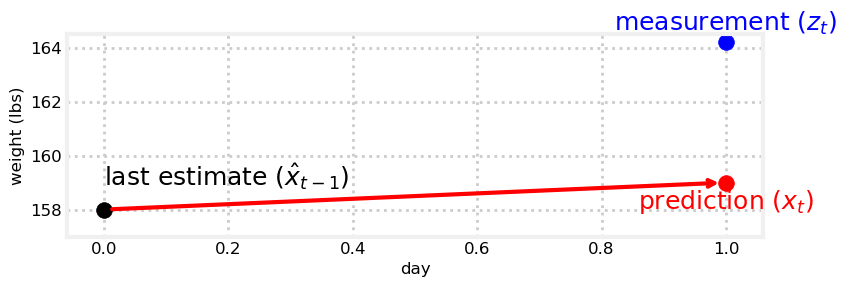

In [21]:
gh.plot_estimate_chart_2()

问题来了，我们的预测与量测矛盾。意料之中，不是么？如果两者一致的话，我们的滤波器就没用了。而且如果一致的话，我们的体重可以靠猜，那还买称干什么呢?

> **注意了，前方高能。本书的精华就在下一段!**

何去何从？如果只用量测值，那么预测就没什么用了。如果把预测作为估计值，那么量测值的意义又在哪？要走出困境我们需要的是一种**预测和量测的数据融合方法**（加粗的就是精华所在了）

融合两者 - 似乎又回到了两个称的问题。根据之前的经验我们只需在预测值和量测值之间选一个数即可。那么，估计165或者157都是不合适的，我们的估计值应介于159(预测值)和164.2(量测值)之间。

再罗嗦一下，我们应该有这个意识，当我们进行数据融合时，我们的估计值应介于两个数值加。这与这两个数的来源无关。本问的开始我们用的是两个量测值，现在我们用一个量测值一个预测值。其中蕴含的数学原理是一样的。我们**永不**抛弃数据。我是认真的。很多商业软件做数据剔除。这很不好！虽然我们预测数据不准，但依然有可取之处。

现在你可以思考一下。这里我做的只不过把一个不准的称换成了基于人体实际状况的预测。从数学上来讲，并不区分这个数据是称称出来的还是一个预测值。这是两个都有噪声的数据，我们要做的就是融合他们。本书中还会设计一些很复杂的滤波算法，但无论如何，数学上讲，数据从哪里来都一样，算法只关心数据的值和精度两个信息。

我们的估计值取量测和预计的均值么？或许吧，可通常情况下我们的预计或多或少比称好点儿，或许这取决于称。记得之前我们一个好称A和一个次称B的处理么？我们让估计离A近一点。看图吧。

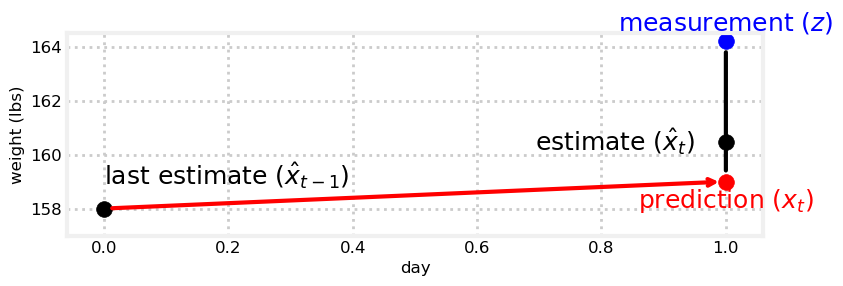

In [22]:
gh.plot_estimate_chart_3()

我们先随便选个数: $\frac{4}{10}$.预测和量测六四分。换句话说，我们认为自己预测的比称准，准多少呢？准两分。于是，我们按照下边的公式做估计，

$$\mathtt{estimate} = \mathtt{prediction} + \frac{4}{10}(\mathtt{measurement} - \mathtt{prediction})$$

量测和预测的差叫做*残差*，即上图中的垂直黑线。这个值很重要，以后会用到。这个值也表征了量测和滤波输出的差异，残差越小往往说明滤波性能越好。

我们用之前思想实验生成的那组数做个实验。

我已经生成了符合假设模型的数据，换句话说这些数据的真值从160开始，每天加1，在生成的数值上加点儿噪声就可以了。也就是说，第一天的真值是160，第二天的真值为161，依此类推。

我们预计值的初值怎么选呢？滤波器的初始化，言之尚早，我们先用160吧。

In [3]:
from kf_book.book_plots import figsize
import matplotlib.pyplot as plt

weights = [158.0, 164.2, 160.3, 159.9, 162.1, 164.6, 
           169.6, 167.4, 166.4, 171.0, 171.2, 172.6]

time_step = 1.0  # day
scale_factor = 4.0/10

def predict_using_gain_guess(estimated_weight, gain_rate, do_print=False):     
    # storage for the filtered results
    estimates, predictions = [estimated_weight], []

    # most filter literature uses 'z' for measurements
    for z in weights: 
        # predict new position
        predicted_weight = estimated_weight + gain_rate * time_step

        # update filter 
        estimated_weight = predicted_weight + scale_factor * (z - predicted_weight)

        # save and log
        estimates.append(estimated_weight)
        predictions.append(predicted_weight)
        if do_print:
            gh.print_results(estimates, predicted_weight, estimated_weight)

    return estimates, predictions

initial_estimate = 160.
estimates, predictions = predict_using_gain_guess(
    estimated_weight=initial_estimate, gain_rate=1, do_print=True)     

上次估计: 160.00, 预测: 161.00, 估计 159.80
上次估计: 159.80, 预测: 160.80, 估计 162.16
上次估计: 162.16, 预测: 163.16, 估计 162.02
上次估计: 162.02, 预测: 163.02, 估计 161.77
上次估计: 161.77, 预测: 162.77, 估计 162.50
上次估计: 162.50, 预测: 163.50, 估计 163.94
上次估计: 163.94, 预测: 164.94, 估计 166.80
上次估计: 166.80, 预测: 167.80, 估计 167.64
上次估计: 167.64, 预测: 168.64, 估计 167.75
上次估计: 167.75, 预测: 168.75, 估计 169.65
上次估计: 169.65, 预测: 170.65, 估计 170.87
上次估计: 170.87, 预测: 171.87, 估计 172.16


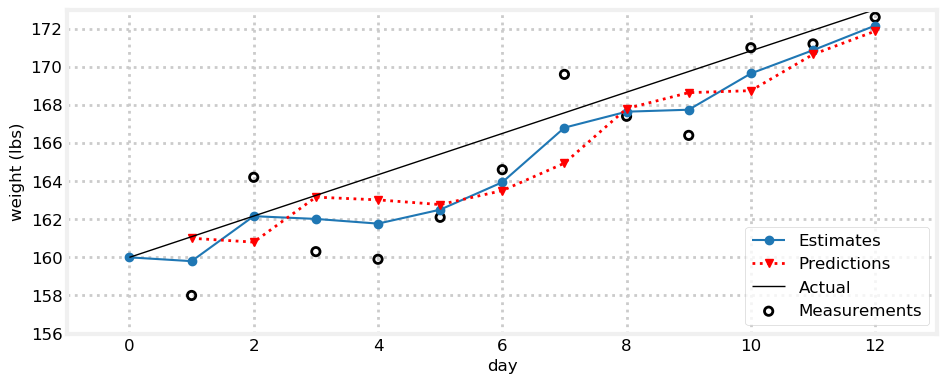

In [23]:
# plot results
book_plots.set_figsize(10)
gh.plot_gh_results(weights, estimates, predictions, [160, 173])

我们来看一下这个图。蓝线是估计值，第一天从160开始。红线是基于上一天估计值的预测值。所以第一天（天的计数从0开始）是160+1=161.第一天的估计值介于161和量测159.8之间。我们在程序中打印出了上次估计值，预测值和新的估计值。图中的黑线是真值。

你可以自己沿着坐标轴算一下，这样可以加深一下理解。

估计值的连接线并不是一条直线，但至少比量测值的曲线要接近直线，而且和真值表征的趋势线是接近的。更有意思的是，随着时间的增长滤波效果变得更好了。

你可能说，这不废话么。真相就是每天增1，我们的预计也是每天增1.那我们来看看我们的预计不靠谱的情况吧。现在假设我们每天减1磅。

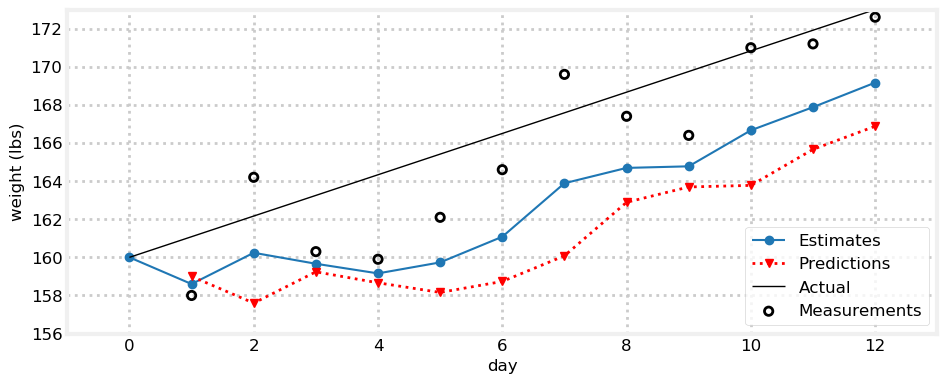

In [24]:
e, p = predict_using_gain_guess(initial_estimate, -1.)
gh.plot_gh_results(weights, e, p, [160, 173])

这个结果就不尽如人意了。我们的估计值很快就跑飞了。所以，一个准确的体重变化猜测对滤波性能很重要。即便我们的初值是准确的，变化率不对，滤波器也失败了。如果我不吃这么多了（实际体重增长不再是每天加1），这个滤波器很难去跟踪这个变化。注意了，滤波器一直试图跟踪！看图可知，即便我们告诉滤波器我每天减1磅，滤波器的结果还是爬升，只不过跟踪的不够快。

既然如此，我们何不使用量测和估计值计算体重增速，就别预计一个不变量了。因此第1天（请习惯天的计数从0开始）的体重是：

$$
(160 + 1) + \frac{4}{10}(158-161) = 159.8
$$

下一天我们的量测是164.2，说明什么呢？我们一天体重增加了4.4 (164.2-159.8=4.4) 而不是1.我们就直接用这个4.4？这么做也合情合理。毕竟量测来自体重，里面包含了有用信息。而我们的估计值虽然不完美，但至少比瞎猜一个1磅/天要强。换句话说，有噪声的数据总比瞎猜强。

对于上述观点好多人持保留意见，不过希望你能认可。两个带噪声的量测可以计算体重增速。当然不准确的量测会带来不准确的估计，这没什么，廖胜于无。你可以想象用误差是1磅的称去称牛的重量，结果显示牛每天涨10磅。对这头牛来说真实的增速可能是8也可能是12（这两个已经是误差极限了），但是我们可以确定它在涨，而且这个增速约等于10.这就是信息。有啥用呢？先别急，且听我慢慢道来。

回到我们的思想实验。我们要把体重增速调整为4.4么？之前我们预计的值是1，现在我们认为是4.4.矛盾产生了，我们需要一种融合。哇，这不就是我们之前讨论的问题么？我们使用相同的方法融合体重增速（当然目前为止我们只有一个方法-从两者的中间选一个数）。这次我用$\frac{1}{3}$作为融合比例。我们使用与体重融合相同的公式，不过得考虑时间，因为我们现在融合的是速的。

$$
\text{new gain} = \text{old gain} + \frac{1}{3}\frac{\text{measurement - predicted weight}}{1 \text{ day}}
$$

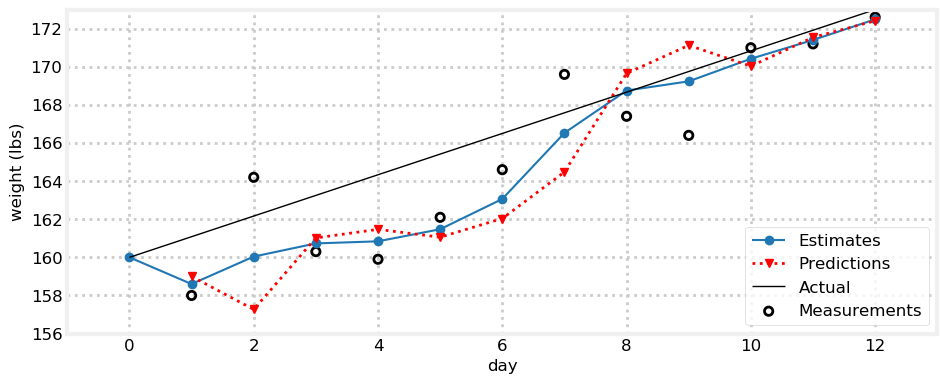

In [28]:
weight = 160.  # initial guess
gain_rate = -1.0  # initial guess

time_step = 1.
weight_scale = 4./10
gain_scale = 1./3
estimates = [weight]
predictions = []

for z in weights:
    # prediction step
    weight = weight + gain_rate*time_step
    gain_rate = gain_rate
    predictions.append(weight)
    
    # update step    
    residual = z - weight
    
    gain_rate = gain_rate + gain_scale   * (residual/time_step)
    weight    = weight    + weight_scale * residual
  
    estimates.append(weight)

gh.plot_gh_results(weights, estimates, predictions, [160, 173])

这个结果就不错了。因为错误的初始猜想（每天下降1磅）导致滤波器经过好几天才缓过神来，可是一旦滤波器回归到正确的轨道就可以比较高精度的跟踪真实体重。目前为止，我们对两个融合比例参数$\frac{4}{10}$ 和 $\frac{1}{3}$的选择很随意（实际上这是两个很糟糕的选择）。

声明一点，在滤波器的时间更新（prediction step）中，体重增速使用以下公式，
```python
gain_rate = gain_rate
``` 
当然了，对程序运行来说这行代码无任何意义。我把它写在这里只是想说，滤波器的时间更新中，我们应该对所有的状态量（体重和体重增量）进行一步更新。本例中我们的模型认为体重增量保持不变，当将滤波器的算法进行泛化时，这一假设当然会去除。

## g-h 滤波

[g-h 滤波](https://en.wikipedia.org/wiki/Alpha_beta_filter) 也叫 $\alpha$-$\beta$ 滤波. $g$ 和 $h$ 表示我们例子中使用的两个比例系数。$g$是用于量测的系数（我们例子中的体重），$h$是用于量测变化率的系数（我们例子中的体重变化率）。$\alpha$ 和 $\beta$是另一种叫法。 

g-h滤波是大量滤波器的基础，包括赫赫有名的卡尔曼滤波。换句话说，卡尔曼滤波是g-h滤波的一个特例(这个观点在本书中我会证明)。你很可能听过的最小二乘滤波也是。Benedict-Bordner滤波也是，当然这个滤波你很可能没听过。这些滤波器都有自己的$g$和$h$计算算法，可除此之外都一样。例如，Benedict-Bordner滤波使用常数$g$ $h$.卡尔曼滤波则对参数进行动态计算。

**重要的是说三遍**. 如果你不认可以下观点，那相信你很难读懂（认可）此书。如果你把以下几句话弄懂了，那么本书的剩余部分将会一马平川。

* 多个数据点总比一个好，所以不要剔除所谓的低精度数据
* 估计值要介于两个数据之间
* 我们的预测（时间更新）要基于上一步估计值和变化率
* 新的估计值介于预测值和量测值之间，融合比例取决于两者各自的精度

也可以用下边的图表示，predict step就是预测，也就是时间更新，输出的叫预测值，update step就是量测更新，输出的是新的估计.

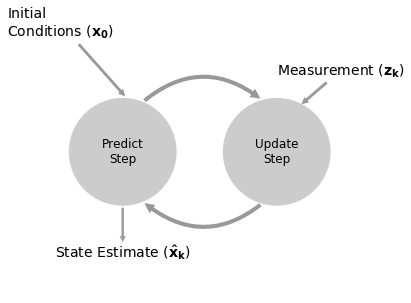

In [11]:
book_plots.predict_update_chart()

Let me introduce some more formal terminology. The *system* is the object that we want to estimate. In this chapter the system is whatever we are trying to weigh. Some 教科书 call this the *plant*. That terminology comes from control system theory. https://en.wikipedia.org/wiki/Plant_(control_theory)

The *state* of the system is the current configuration or values of that system that is of interest to us. We are interested only in the weight reading. If I put a 100 kg weight on the scale, the state is 100kg. We define the state based on what is relevant to us. The color of the scale is irrelevant to us so we do not include those values in the state. A QA engineer for the manufacturer might include color in the state so that she can track and control the manufacturing process. 

The *measurement* is a measured value of the system. Measurements can be inaccurate, so it may not have the same value as the state.

The *state estimate* is our filter's estimate of the state. For example, for the 100 kg weight our estimate might be 99.327 kg due to sensor errors. This is commonly abbreviated to *estimate*, and I have done that in this chapter.

In other words, the state should be understood as the actual value of the system. This value is usually *hidden* to us.  If I stepped on a scale you'd then have a *measurement*. We call this *observable* since you can directly observe this measurement. In contrast, you can never directly observe my weight, you can only measure it. 

This language of *hidden* and *observable* is important. Any estimation problem consists of forming an estimate of a hidden state via observable measurements. If you read the literature these terms are used when defining a problem, so you need to be comfortable with them.

We use a *process model* to mathematically model the system. In this chapter our process model is the assumption that my weight today is yesterday's weight plus my weight gain for the last day. The process model does not model or otherwise account for the sensors. Another example would be a process model for an automobile. The process model might be "distance equals velocity times time. This model is not perfect as the velocity of a car can vary over a non-zero amount of time, the tires can slip on the road, and so on. The *system error* or *process error* is the error in this model. We never know this value exactly; if we did we could refine our model to have zero error. Some texts use *plant model* and *plant error*. You may also see *system model*. They all mean the same thing.

The predict step is known as *system propagation*. It uses the *process model* to form a new *state estimate*. Because of the *process error* this estimate is imperfect. Assuming we are tracking data over time, we say we *propagate* the state into the future. Some texts call this the *evolution*. 

The update step is known as the *measurement update*. One iteration of the system propagation and measurement update is known as an *epoch*. 

Now let's explore a few different problem domains to better understand this algorithm. Consider the problem of trying to track a train on a track. The track constrains the position of the train to a very specific region. Furthermore, trains are large and slow. It takes many minutes for them to slow down or speed up significantly. So, if I know that the train is at kilometer marker 23 km at time t and moving at 18 kph, I can be extremely confident in predicting its position at time t + 1 second. Why is that important? Suppose we can only measure its position with an accuracy of $\pm$ 250 meters. The train is moving at 18 kph, which is 5 meters per second. At t+1 seconds the train will be at 23.005 km yet the measurement could be anywhere from 22.755 km to 23.255 km. So if the next measurement says the position is at 23.4 we know that must be inaccurate. Even if at time t the engineer slammed on the brakes the train will still be very near to 23.005 km because a train cannot slow down very much in 1 second. If we were to design a filter for this problem (and we will a bit further in the chapter!) we would want to design a filter that gave a very high weighting to the prediction vs the measurement. 

Now consider the problem of tracking a thrown ball. We know that a ballistic object moves in a parabola in a vacuum when in a gravitational field. But a ball thrown on Earth is influenced by air drag, so it does not travel in a perfect parabola. Baseball pitchers take advantage of this fact when they throw curve balls. Let's say that we are tracking the ball inside a stadium using computer vision, something I do at work. The accuracy of the computer vision tracking might be modest, but predicting the ball's future positions by assuming that it is moving on a parabola is not extremely accurate either. In this case we'd probably design a filter that gave roughly equal weight to the measurement and the prediction.

Now consider trying to track a helium party balloon in a hurricane. We have no legitimate model that would allow us to predict the balloon's behavior except over very brief time scales (we know the balloon cannot go 10 miles in 1 second, for example). In this case we would design a filter that emphasized the measurements over the predictions.

Most of this book is devoted to expressing the concerns in the last three paragraphs mathematically, which then allows us to find an optimal solution (in some mathematical sense). In this chapter we will merely be assigning different values to $g$ and $h$ in a more intuitive, and thus less optimal way. But the fundamental idea is to blend somewhat inaccurate measurements with somewhat inaccurate models of how the systems behaves to get a filtered estimate that is better than either information source by itself.

We can express this as an algorithm:

**Initialization**

    1. Initialize the state of the filter
    2. Initialize our belief in the state

**Predict**

    1. Use system behavior to predict state at the next time step
    2. Adjust belief to account for the uncertainty in prediction
    
**Update**

    1. Get a measurement and associated belief about its accuracy
    2. Compute residual between estimated state and measurement
    3. New estimate is somewhere on the residual line
    
We will use this same algorithm throughout the book, albeit with some modifications. 

## Notation

I'll begin to introduce the notations and variable names used in the literature. Some of this was already used in the above charts. Measurement is typically denoted $z$ and that is what we will use in this book (some literature uses $y$). Subscript $k$ indicates the time step, so $z_k$ is the data for this time step. A bold font denotes a vector or matrix. So far we have only considered having one sensor, and hence one sensor measurement, but in general we may have *n* sensors and *n* measurements. $\mathbf{x}$ denotes our state, and is bold to denote that it is a vector. For our scale example, it represents both the initial weight and initial weight gain rate, like so:

$$\mathbf{x} = \begin{bmatrix}x \\ \dot{x}\end{bmatrix}$$

Here I use Newton's notation of a dot over the x to denote velocity. More precisely, the dot implies the derivative of x with respect to time, which of course is the velocity. For a weight of 62 kg with a gain of 0.3 kg/day we have

$$\mathbf{x} = \begin{bmatrix}62 \\ 0.3\end{bmatrix}$$

So, the algorithm is simple. The state is initialized with $\mathbf{x_0}$, the initial estimate. We then enter a loop, predicting the state for time or step $k$ from the values from time (or step) $k-1$. We then get the measurement $z_k$ and choose some intermediate point between the measurements and prediction, creating the estimate $\mathbf{x}_k$.

## Exercise: Write Generic Algorithm

In the example above, I explicitly coded this to solve the weighing problem that we've been discussing throughout the chapter. For example, the variables are named "weight_scale", "gain", and so on. I did this to make the algorithm easy to follow - you can easily see that we correctly implemented each step. But, that is code written for exactly one problem, and the algorithm is the same for any problem. So let's rewrite the code to be generic - to work with any problem. Use this function signature:

```python
def g_h_filter(data, x0, dx, g, h, dt):
    """
    Performs g-h filter on 1 state variable with a fixed g and h.

    'data' contains the data to be filtered.
    'x0' is the initial value for our state variable
    'dx' is the initial change rate for our state variable
    'g' is the g-h's g scale factor
    'h' is the g-h's h scale factor
    'dt' is the length of the time step 
    """
```

Return the data as a NumPy array, not a list. Test it by passing in the same weight data as before, plot the results, and visually determine that it works.

In [21]:
def g_h_filter(data, x0, dx, g, h, dt):
    pass #  your solution here

# uncomment to run the filter and plot the results
#book_plots.plot_track([0, 11], [160, 172], label='Actual weight')
#data = g_h_filter(data=weights, x0=160., dx=1., g=6./10, h=2./3, dt=1.)
#plot_g_h_results(weights, data)

### Solution and Discussion

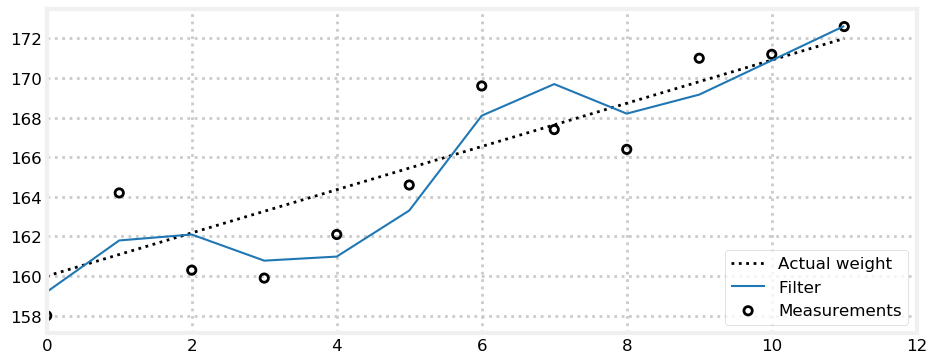

In [22]:
from kf_book.gh_internal import plot_g_h_results
import matplotlib.pylab as pylab

def g_h_filter(data, x0, dx, g, h, dt=1.):
    x_est = x0
    results = []
    for z in data:
        # prediction step
        x_pred = x_est + (dx*dt)
        dx = dx

        # update step
        residual = z - x_pred
        dx = dx + h * (residual) / dt
        x_est = x_pred + g * residual
        results.append(x_est)
    return np.array(results)

book_plots.plot_track([0, 11], [160, 172], label='Actual weight')
data = g_h_filter(data=weights, x0=160., dx=1., g=6./10, h=2./3, dt=1.)
plot_g_h_results(weights, data)

This should have been straightforward. I just subtituted the variable names `x0`, `dx`, etc., for the variable names in the weight gain code. Nothing else needed to change.

## Choice of $g$ and $h$

The g-h filter is not one filter - it is a classification for a family of filters. Eli Brookner in *Tracking and Kalman Filtering Made Easy* lists 11, and I am sure there are more. Not only that, but each type of filter has numerous subtypes. Each filter is differentiated by how $g$ and $h$ are chosen. So there is no 'one size fits all' advice that I can give here. Some filters set $g$ and $h$ as constants, others vary them dynamically. The Kalman filter varies them dynamically at each step. Some filters allow $g$ and $h$ to take any value within a range, others constrain one to be dependent on the other by some function $f(\dot{}), \mbox{where }g = f(h)$.

The topic of this book is not the entire family of g-h filters; more importantly, we are interested in the *Bayesian* aspect of these filters, which I have not addressed yet. Therefore I will not cover selection of $g$ and $h$ in depth. *Tracking and Kalman Filtering Made Easy* is an excellent resource for that topic. If this strikes you as an odd position for me to take, recognize that the typical formulation of the Kalman filter does not use $g$ and $h$ at all. The Kalman filter is a g-h filter because it mathematically reduces to this algorithm. When we design the Kalman filter we use design criteria that can be mathematically reduced to $g$ and $h$, but the Kalman filter form is usually a much more powerful way to think about the problem. Don't worry if this is not too clear right now, it will clear once we develop the Kalman filter theory.

It is worth seeing how varying $g$ and $h$ affects the results, so we will work through some examples. This will give us strong insight into the fundamental strengths and limitations of this type of filter, and help us understand the behavior of the rather more sophisticated Kalman filter.

## Exercise: create measurement function

Now let's write a function that generates noisy data for us. In this book I model a noisy signal as the signal plus [white noise](https://en.wikipedia.org/wiki/White_noise). We've not yet covered the statistics to fully understand the definition of white noise. In essence, think of it as data that randomly varies higher and lower than the signal with no pattern. We say that it is a serially uncorrelated random variable with zero mean and finite variance. If you don't follow that, you will by the end of the *Gaussians* chapter. You may not be successful at this exercise if you have no knowledge of statistics. If so, just read the solution and discussion.

White noise can be generated by `numpy.random.randn()`. We want a function that we call with the starting value, the amount of change per step, the number of steps, and the amount of noise we want to add. It should return a list of the data. Test it by creating 30 points, filtering it with `g_h_filter()`, and plot the results with `plot_g_h_results()`.

In [23]:
# your code here

### Solution

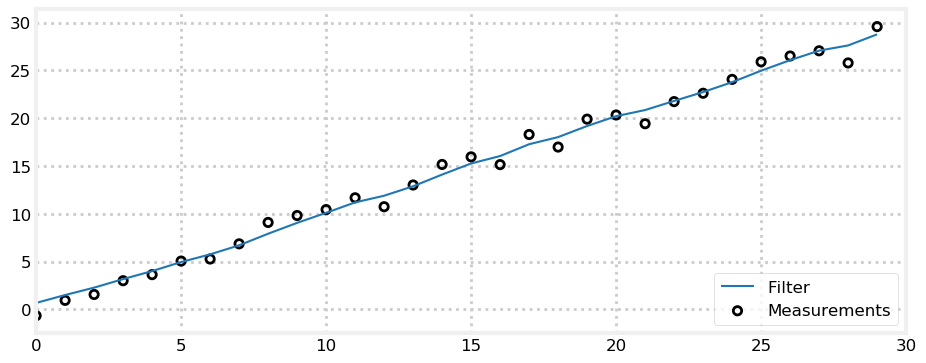

In [24]:
from numpy.random import randn
def gen_data(x0, dx, count, noise_factor):
    return [x0 + dx*i + randn()*noise_factor for i in range(count)]

measurements = gen_data(0, 1, 30, 1)
data = g_h_filter(data=measurements, x0=0., dx=1., dt=1., g=.2, h=0.02)
plot_g_h_results(measurements, data)

### Discussion

`randn()` returns random numbers centered around 0 - it is just as likely to be greater than zero as under zero. It varies by *one standard deviation* - don't worry if you don't know what that means. I've plotted 3000 calls to `randn()` - you can see that the values are centered around zero and mostly range from a bit under -1 to a bit more than +1, though occasionally they are much larger.

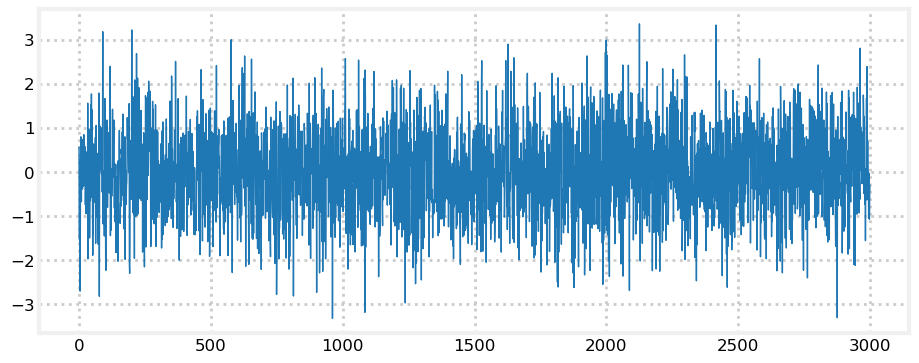

In [25]:
plt.plot([randn() for _ in range(3000)], lw=1);

## Exercise: Bad Initial Conditions

Now write code that uses `gen_data` and `g_h_filter` to filter 100 data points that starts at 5, has a derivative of 2, a noise scaling factor of 10, and uses g=0.2 and h=0.02. Set your initial guess for x to be 100.

In [26]:
# your code here

### Solution and Discussion

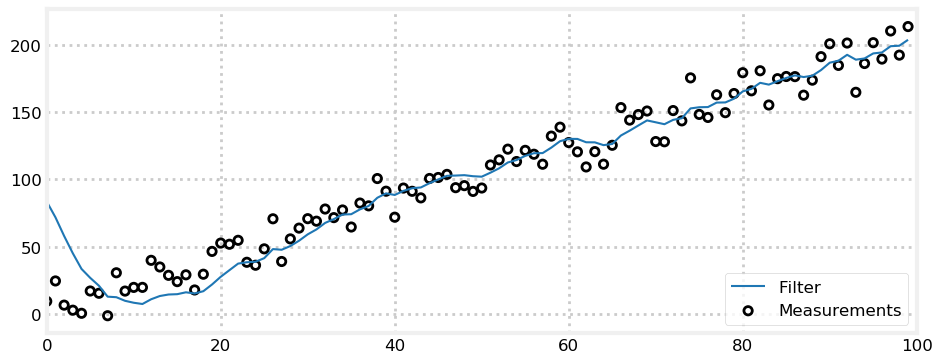

In [27]:
zs = gen_data(x0=5., dx=2., count=100, noise_factor=10)
data = g_h_filter(data=zs, x0=100., dx=2., dt=1., g=0.2, h=0.02)
plot_g_h_results(measurements=zs, filtered_data=data)

The filter starts out with estimates that are far from the measured data due to the bad initial guess of 100. You can see that it 'rings' before settling in on the measured data. 'Ringing' means that the signal overshoots and undershoots the data in a sinusoidal type pattern. This is a very common phenomena in filters, and a lot of work in filter design is devoted to minimizing ringing. That is a topic that we are not yet prepared to address, but I wanted to show you the phenomenon.

## Exercise: Extreme Noise

Rerun the same test, but this time use a noise factor of 100. Remove the initial condition ringing by changing the initial condition from 100 down to 5.

In [28]:
# your code here

### Solution and Discussion

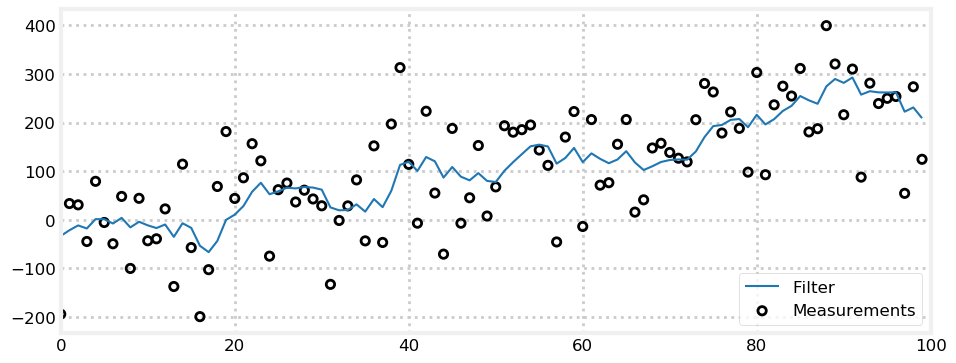

In [29]:
zs = gen_data(x0=5., dx=2., count=100, noise_factor=100)
data = g_h_filter(data=zs, x0=5., dx=2., g=0.2, h=0.02)
plot_g_h_results(measurements=zs, filtered_data=data)

This doesn't look so wonderful to me. We can see that perhaps the filtered signal varies less than the noisy signal, but it is far from the straight line. If we were to plot just the filtered result no one would guess that the signal starts at 5 and increments by 2 at each time step. And while in locations the filter does seem to reduce the noise, in other places it seems to overshoot and undershoot.

At this point we don't know enough to really judge this. We added **a lot** of noise; maybe this is as good as filtering can get. However, the existence of the multitude of chapters beyond this one should suggest that we can do much better.

## Exercise: The Effect of Acceleration

Write a new data generation function that adds in a constant acceleration factor to each data point. In other words, increment dx as you compute each data point so that the velocity (dx) is ever increasing. Set the noise to 0, $g=0.2$ and $h=0.02$ and plot the results. Explain what you see.

In [30]:
# your code here

### Solution and Discussion

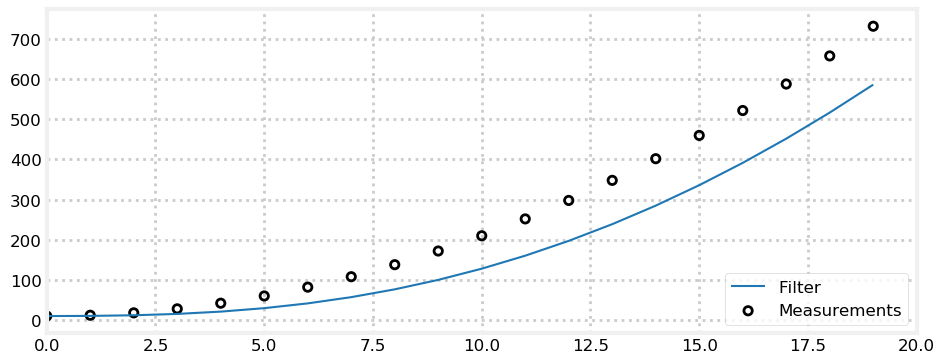

In [31]:
def gen_data(x0, dx, count, noise_factor, accel=0.):
    zs = []
    for i in range(count):
        zs.append(x0 + dx*i + randn()*noise_factor)
        dx += accel
    return zs
   
predictions = []
zs = gen_data(x0=10., dx=0., count=20, noise_factor=0, accel=2.)
data = g_h_filter(data=zs, x0=10., dx=0., g=0.2, h=0.02)
plt.xlim([0, 20])
plot_g_h_results(measurements=zs, filtered_data=data)

Each prediction lags behind the signal. If you think about what is happening this makes sense. Our model assumes that velocity is constant. The g-h filter computes the first derivative of $x$ (we use $\dot{x}$ to denote the derivative) but not the second derivative $\ddot{x}$. So we are assuming that $\ddot{x}=0$. At each prediction step we predict the new value of x as $x + \dot{x}*t$. But because of the acceleration the prediction must necessarily fall behind the actual value. We then try to compute a new value for $\dot{x}$, but because of the $h$ factor we only partially adjust $\dot{x}$ to the new velocity. On the next iteration we will again fall short.

Note that there is no adjustment to $g$ or $h$ that we can make to correct this problem. This is called the *lag error* or *systemic error* of the system. It is a fundamental property of g-h filters. Perhaps your mind is already suggesting solutions or workarounds to this problem. As you might expect, a lot of research has been devoted to this problem, and we will be presenting various solutions to this problem in this book.
> The 'take home' point is that the filter is only as good as the mathematical model used to express the system. 

## Exercise: Varying $g$

Now let's look at the effect of varying $g$. Before you perform this exercise, recall that $g$ is the scale factor for choosing between the measurement and prediction. What do you think the effect of a large value of $g$ will be? A small value?

Now, let the `noise_factor=50` and `dx=5`. Plot the results of $g = 0.1\mbox{, } 0.4,\mbox{ and } 0.8$.

In [32]:
# your code here

### Solution and Discussion

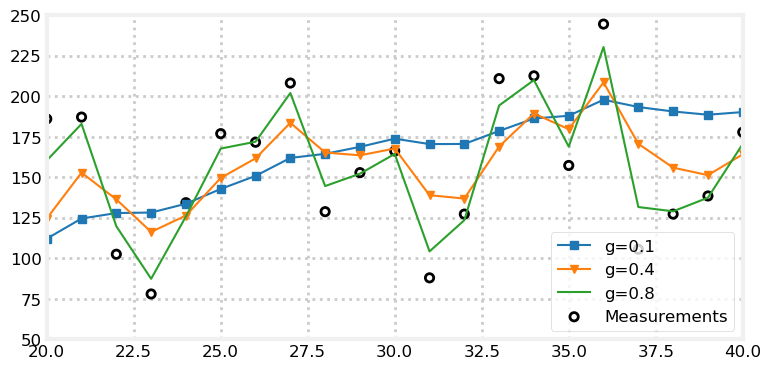

In [33]:
np.random.seed(100)
zs = gen_data(x0=5., dx=5., count=50, noise_factor=50)
data1 = g_h_filter(data=zs, x0=0., dx=5., dt=1., g=0.1, h=0.01)
data2 = g_h_filter(data=zs, x0=0., dx=5., dt=1., g=0.4, h=0.01)
data3 = g_h_filter(data=zs, x0=0., dx=5., dt=1., g=0.8, h=0.01)

with book_plots.figsize(y=4):
    book_plots.plot_measurements(zs, color='k')
    book_plots.plot_filter(data1, label='g=0.1', marker='s', c='C0')
    book_plots.plot_filter(data2, label='g=0.4', marker='v', c='C1')
    book_plots.plot_filter(data3, label='g=0.8', c='C2')
    plt.legend(loc=4)
    book_plots.set_limits([20, 40], [50, 250])

It is clear that as $g$ is larger we more closely follow the measurement instead of the prediction. When $g=0.8$ we follow the signal almost exactly, and reject almost none of the noise. One might naively conclude that $g$ should always be very small to maximize noise rejection. However, that means that we are mostly ignoring the measurements in favor of our prediction. What happens when the signal changes not due to noise, but an actual state change? Let's have a look. I will create data that has $\dot{x}=1$ for 9 steps before changing to $\dot{x}=0$. 

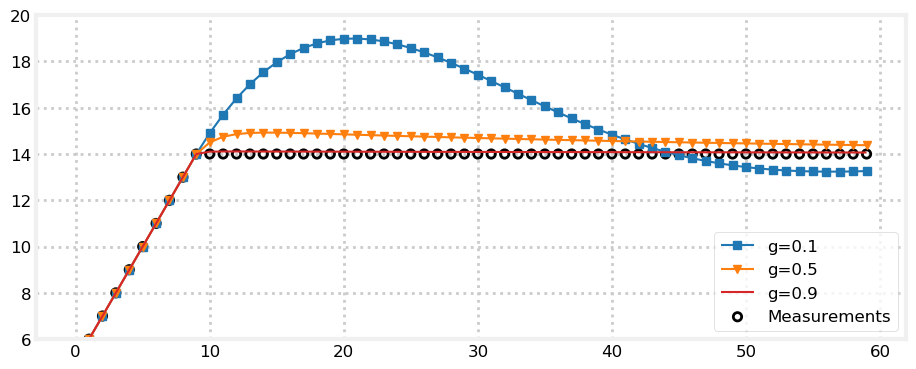

In [34]:
zs = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
for i in range(50):
    zs.append(14)

data1 = g_h_filter(data=zs, x0=4., dx=1., dt=1., g=0.1, h=0.01)
data2 = g_h_filter(data=zs, x0=4., dx=1., dt=1., g=0.5, h=0.01)
data3 = g_h_filter(data=zs, x0=4., dx=1., dt=1., g=0.9, h=0.01)

book_plots.plot_measurements(zs)
book_plots.plot_filter(data1, label='g=0.1', marker='s', c='C0')
book_plots.plot_filter(data2, label='g=0.5', marker='v', c='C1')
book_plots.plot_filter(data3, label='g=0.9', c='C3')
plt.legend(loc=4)
plt.ylim([6, 20]);

Here we can see the effects of ignoring the signal. We not only filter out noise, but legitimate changes in the signal as well. 

Maybe we need a 'Goldilocks' filter, where $g$ is not too large, not too small, but just right? Well, not exactly. As alluded to earlier, different filters choose $g$ and $h$ in different ways depending on the mathematical properties of the problem. For example, the Benedict-Bordner filter was invented to minimize the transient error in this example, where $\dot{x}$ makes a step jump. We will not discuss this filter in this book, but here are two plots chosen with different allowable pairs of $g$ and $h$. This filter design minimizes transient errors for step jumps in $\dot{x}$ at the cost of not being optimal for other types of changes in $\dot{x}$.

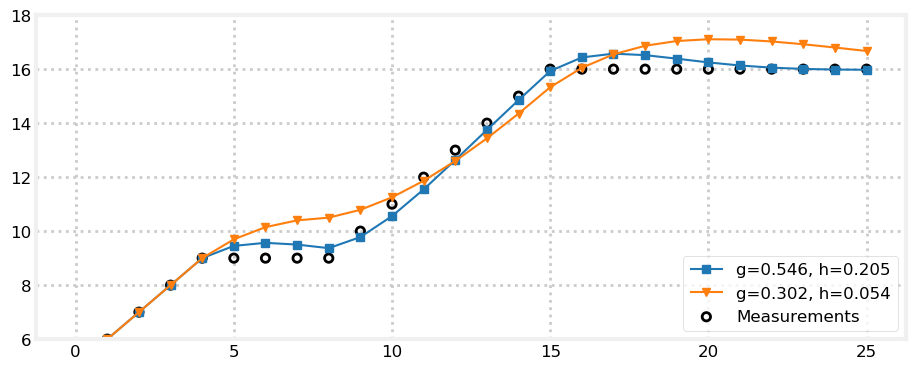

In [35]:
zs = [5,6,7,8,9,9,9,9,9,10,11,12,13,14,
      15,16,16,16,16,16,16,16,16,16,16,16]
data1 = g_h_filter(data=zs, x0=4., dx=1., dt=1., g=.302, h=.054)
data2 = g_h_filter(data=zs, x0=4., dx=1., dt=1., g=.546, h=.205)

book_plots.plot_measurements(zs)
book_plots.plot_filter(data2, label='g=0.546, h=0.205', marker='s', c='C0')
book_plots.plot_filter(data1, label='g=0.302, h=0.054', marker='v', c='C1')
plt.legend(loc=4)
plt.ylim([6, 18]);

## Varying $h$

Now let's leave $g$ unchanged and investigate the effect of modifying $h$. We know that $h$ affects how much we favor the measurement of $\dot{x}$ vs our prediction. But what does this *mean*? If our signal is changing a lot (quickly relative to the time step of our filter), then a large $h$ will cause us to react to those transient changes rapidly. A smaller $h$ will cause us to react more slowly.

We will look at three examples. We have a noiseless measurement that slowly goes from 0 to 1 in 50 steps. Our first filter uses a nearly correct initial value for $\dot{x}$ and a small $h$. You can see from the output that the filter output is very close to the signal. The second filter uses the very incorrect guess of $\dot{x}=2$. Here we see the filter 'ringing' until it settles down and finds the signal. The third filter uses the same conditions but it now sets $h=0.5$. If you look at the amplitude of the ringing you can see that it is much smaller than in the second chart, but the frequency is greater. It also settles down a bit quicker than the second filter, though not by much.

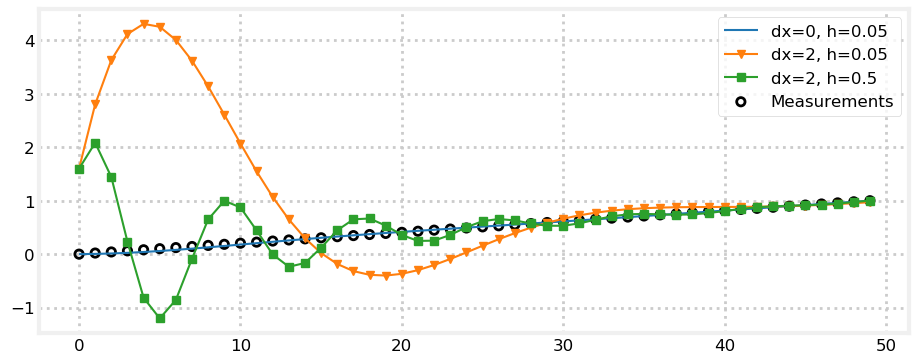

In [36]:
zs = np.linspace(0, 1, 50)

data1 = g_h_filter(data=zs, x0=0, dx=0., dt=1., g=.2, h=0.05)
data2 = g_h_filter(data=zs, x0=0, dx=2., dt=1., g=.2, h=0.05)
data3 = g_h_filter(data=zs, x0=0, dx=2., dt=1., g=.2, h=0.5)

book_plots.plot_measurements(zs)
book_plots.plot_filter(data1, label='dx=0, h=0.05', c='C0')
book_plots.plot_filter(data2, label='dx=2, h=0.05', marker='v', c='C1')
book_plots.plot_filter(data3, label='dx=2, h=0.5',  marker='s', c='C2')
plt.legend(loc=1);

## Interactive Example

For those of you running this in Jupyter Notebook I've written an interactive version of the filter so you can see the effect of changing $\dot{x}$, $g$ and $h$ in real time. As you adjust the sliders for $\dot{x}$, $g$ and $h$ the data will be refiltered and the results plotted for you.

If you really want to test yourself, read the next paragraph and try to predict the results before you move the sliders. 

Some things to try include setting $g$  and $h$ to their minimum values. See how perfectly the filter tracks the data! This is only because we are perfectly predicting the weight gain. Adjust $\dot{x}$ to larger or smaller than 5. The filter should diverge from the data and never reacquire it. Start adding back either $g$ or $h$ and see how the filter snaps back to the data. See what the difference in the line is when you add only $g$ vs only $h$. Can you explain the reason for the difference? Then try setting $g$ greater than 1. Can you explain the results? Put $g$ back to a reasonable value (such as 0.1), and then make $h$ very large. Can you explain these results? Finally, set both $g$ and $h$ to their largest values. 
 
If you want to explore with this more, change the value of the array `zs` to the values used in any of the charts above and rerun the cell to see the result.

In [37]:
from ipywidgets import interact

# my FloatSlider returns an ipywidgets.FloatSlider with
# continuous_update=False. Filtering code runs too slowly
# to instantly react to slider changes.
from kf_book.book_plots import FloatSlider

zs1 = gen_data(x0=5, dx=5., count=100, noise_factor=50)

fig = None
def interactive_gh(x, dx, g, h):
    global fig
    if fig is not None: plt.close(fig)
    fig = plt.figure()
    data = g_h_filter(data=zs1, x0=x, dx=dx, g=g, h=h)
    plt.scatter(range(len(zs1)), zs1, edgecolor='k', 
                facecolors='none', marker='o', lw=1)
    plt.plot(data, color='b')

interact(interactive_gh,           
         x=FloatSlider(value=0, min=-200, max=200), 
         dx=FloatSlider(value=5, min=-50, max=50), 
         g=FloatSlider(value=.1, min=.01, max=2, step=.02), 
         h=FloatSlider(value=.02, min=.0, max=.5, step=.01));

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='x', max=200.0, min=-200.0),…

## Don't Lie to the Filter

You are free to set $g$ and $h$ to any value. Here is a filter that performs perfectly despite extreme noise.

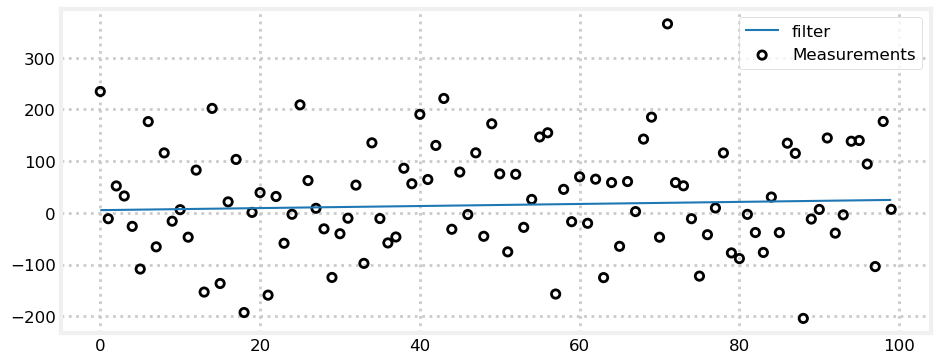

In [38]:
zs = gen_data(x0=5., dx=.2, count=100, noise_factor=100)
data = g_h_filter(data=zs, x0=5., dx=.2, dt=1., g=0., h=0.)

book_plots.plot_measurements(zs)
book_plots.plot_filter(data, label='filter')
plt.legend(loc=1);

I brilliantly extracted a straight line out of very noisy data! Maybe I shouldn't try to collect my Fields Medal in mathematics just yet. I did this by setting both $g$ and $h$ to 0. What does this do? It makes the filter ignore the measurements, and so for each update it computes the new position as $x + \Delta x \Delta t$. Of course the result is a straight line if we ignore the measurements. 

A filter that ignores measurements is useless. I know you would never set both $g$ and $h$ to zero as that takes a special kind of genius that only I possess, but I promise that if you are not careful you will set them lower than they should be. You can always make great looking results from test data. When you try your filter on different data you will be disappointed in the results because you finely tuned the constants for a specific data set. $g$ and $h$ must reflect the real world behavior of the system you are filtering, not the behavior of one specific data set. In later chapters we will learn a lot about how to do that. For now I can only say be careful, or you will be getting perfect results with your test data, but results like this once you switch to real data:

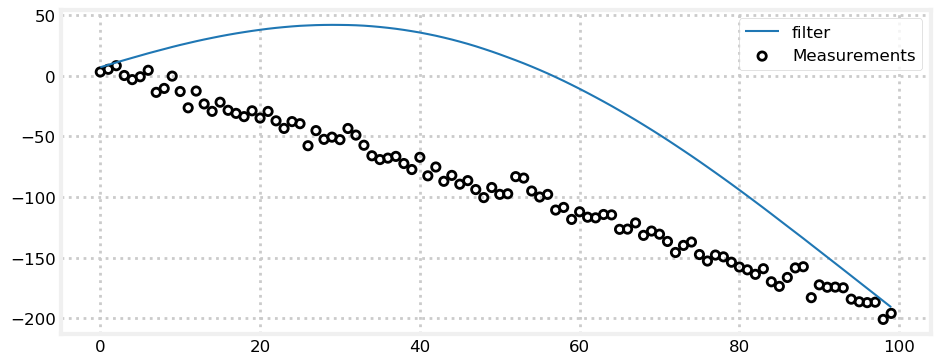

In [39]:
zs = gen_data(x0=5, dx=-2, count=100, noise_factor=5)
data = g_h_filter(data=zs, x0=5., dx=2., dt=1., g=.005, h=0.001)
book_plots.plot_measurements(zs)
book_plots.plot_filter(data, label='filter')
plt.legend(loc=1);

## Tracking a Train

We are ready for a practical example. Earlier in the chapter we talked about tracking a train. Trains are heavy and slow, thus they cannot change speed quickly. They are on a track, so they cannot change direction except by slowing to a stop and then reversing course. Hence, we can conclude that if we already know the train's approximate position and velocity then we can predict its position in the near future with a great deal of accuracy. A train cannot change its velocity much in a second or two. 

So let's write a filter for a train. Its position is expressed as its position on the track in relation to some fixed point which we say is 0 km. I.e., a position of 1 means that the train is 1 km away from the fixed point. Velocity is expressed as meters per second. We perform measurement of position once per second, and the error is $\pm$ 500 meters. How should we implement our filter?

First, let's simulate the situation without a filter. We will assume that the train is currently at kilometer 23, and moving at 15 m/s. We can code this as 

```python
pos = 23*1000
vel = 15
```

Now we can compute the position of the train at some future time, *assuming* no change in velocity, with

```python
def compute_new_position(pos, vel, dt=1):
    return pos + (vel * dt)
```

We can simulate the measurement by adding in some random noise to the position. Here our error is 500m, so the code might look like:

```python
def measure_position(pos):
        return pos + random.randn()*500
```
        
Let's put that in a cell and plot the results of 100 seconds of simulation. I will use NumPy's `asarray` function to convert the data into an NumPy array. This will allow me to divide all of the elements of the array at once by using the '/' operator.

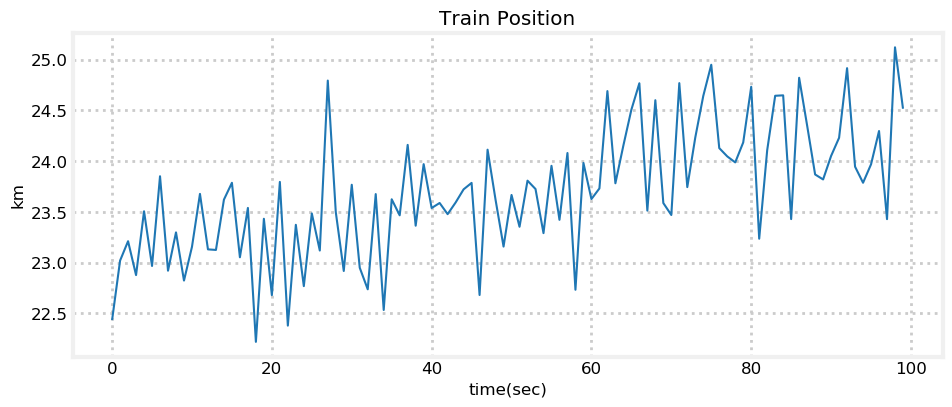

In [40]:
from numpy.random import randn

def compute_new_position(pos, vel, dt=1.):
    """ dt is the time delta in seconds."""
    return pos + (vel * dt)

def measure_position(pos):
    return pos + randn()*500

def gen_train_data(pos, vel, count):
    zs = []
    for t in range(count):
        pos = compute_new_position(pos, vel)
        zs.append(measure_position(pos))
    return np.asarray(zs)
  
pos, vel = 23.*1000, 15.
zs = gen_train_data(pos, vel, 100)

plt.plot(zs / 1000.)  # convert to km
book_plots.set_labels('Train Position', 'time(sec)', 'km')

We can see from the chart how poor the measurements are. No real train could ever move like that. 

So what should we set $g$ and $h$ to if we want to filter this data? We have not developed the theory for this, but let's try to get a reasonable answer by the seat of our pants. We know that the measurements are very inaccurate, so we don't want to give them much weight at all. To do this we need to choose a very small $g$. We also know that trains can not accelerate or decelerate quickly, so we also want a very small $h$. For example:

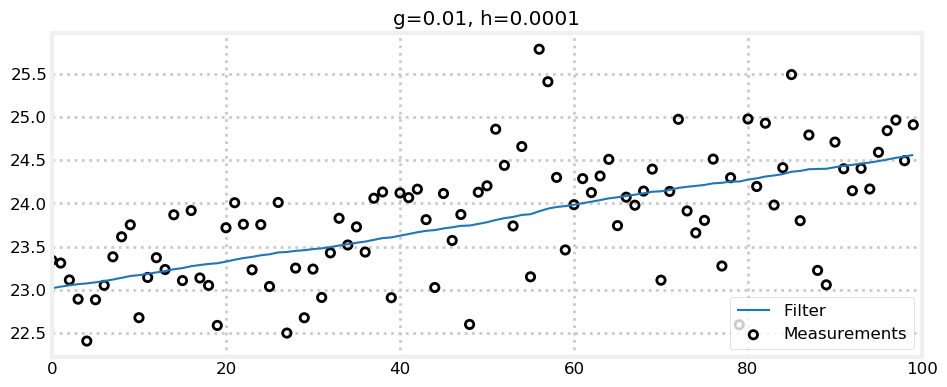

In [41]:
zs = gen_train_data(pos=pos, vel=15., count=100)
data = g_h_filter(data=zs, x0=pos, dx=15., dt=1., g=.01, h=0.0001)
plot_g_h_results(zs/1000., data/1000., 'g=0.01, h=0.0001')

That is pretty good for an initial guess. Let's make $g$ larger to see the effect.

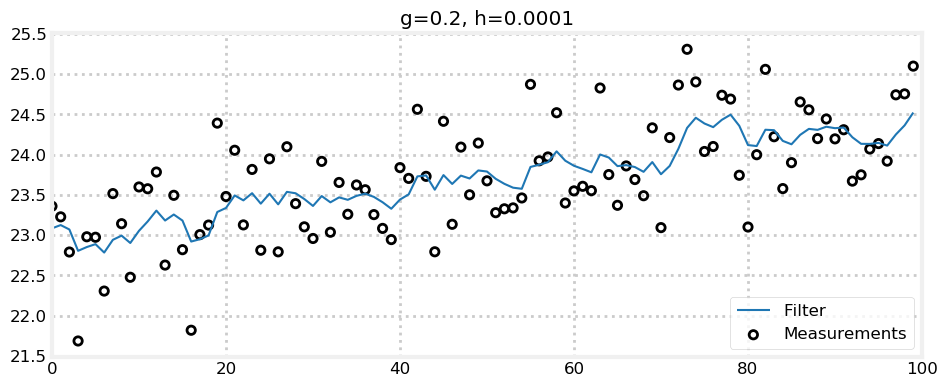

In [42]:
zs = gen_train_data(pos=pos, vel=15., count=100)
data = g_h_filter(data=zs, x0=pos, dx=15., dt=1., g=.2, h=0.0001)
plot_g_h_results(zs/1000., data/1000., 'g=0.2, h=0.0001')

We made `g=0.2` and we can see that while the train's position is smoothed, the estimated position (and hence velocity) fluctuates a lot in a very tiny frame, far more than a real train can do. So empirically we know that we want `g<<0.2`.

Now let's see the effect of a poor choice for $h$.

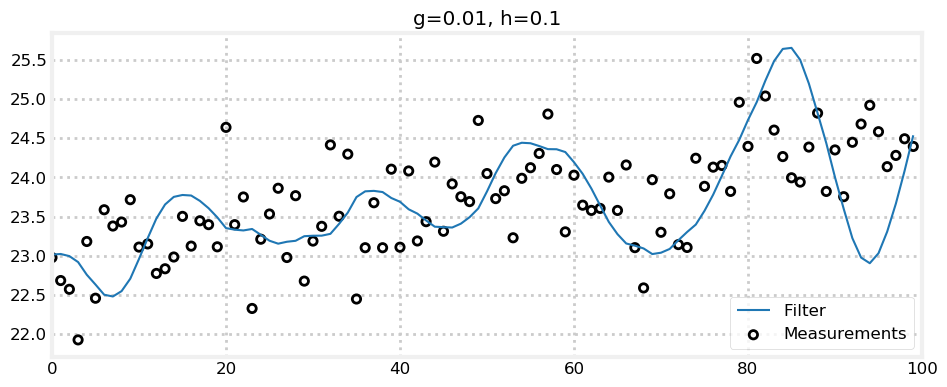

In [43]:
zs = gen_train_data(pos=pos, vel=15., count=100)
data = g_h_filter(data=zs, x0=pos, dx=15., dt=1., g=0.01, h=0.1)
plot_g_h_results(zs/1000., data/1000., 'g=0.01, h=0.1')

Here the position changes smoothly thanks to the small $g$, but the large $h$ makes the filter very reactive to the measurements. This happens because in the course of a few seconds the rapidly changing measurement implies a very large velocity change, and a large $h$ tells the filter to react to those changes quickly. Trains cannot change velocity quickly, so the filter is not doing a good job of filtering the data - the filter is changing velocity faster than a train can.

Finally, let's add some acceleration to the train. I don't know how fast a train can actually accelerate, but let's say it is accelerating at 0.2 m/sec^2. 

In [44]:
def gen_train_data_with_acc(pos, vel, count):
    zs = []
    for t in range(count):
        pos = compute_new_position(pos, vel)
        vel += 0.2
        zs.append(measure_position(pos))
    return np.asarray(zs) 

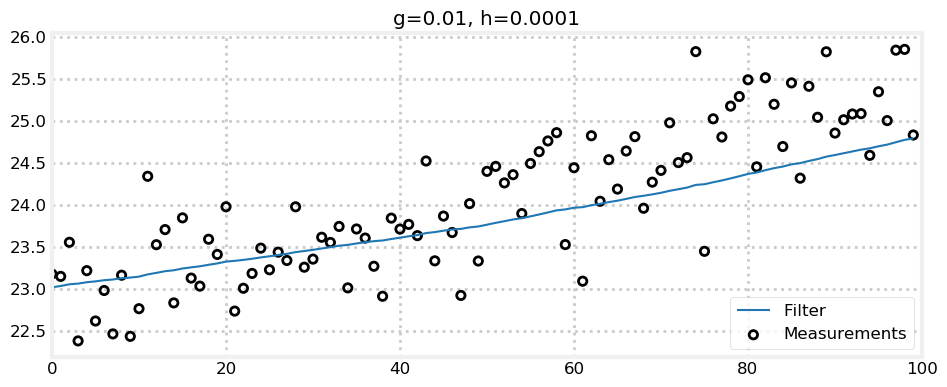

In [45]:
zs = gen_train_data_with_acc(pos=pos, vel=15., count=100)
data = g_h_filter(data=zs, x0=pos, dx=15., dt=1., g=.01, h=0.0001)
plot_g_h_results(zs/1000., data/1000., 'g=0.01, h=0.0001')

Here we see that the filter is not quite tracking the train anymore due to the acceleration. We can fiddle with $h$ to let it track better, at the expense of a less smooth filtered estimate.

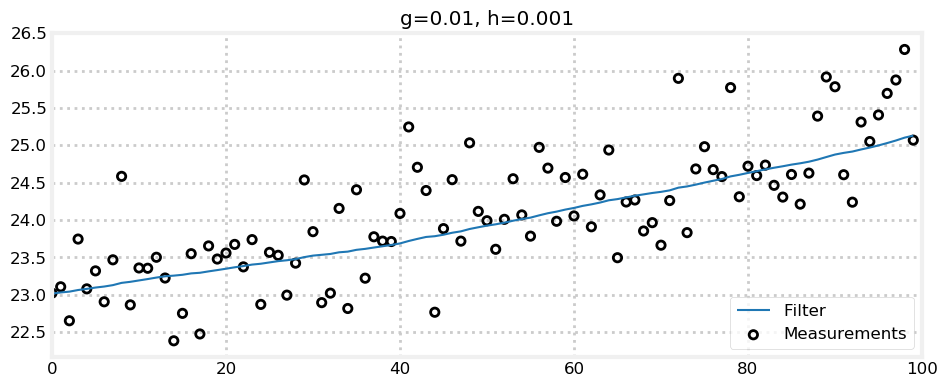

In [46]:
zs = gen_train_data_with_acc(pos=pos, vel=15., count=100)
data = g_h_filter(data=zs, x0=pos, dx=15., dt=1., g=.01, h=0.001)
plot_g_h_results(zs/1000., data/1000., 'g=0.01, h=0.001')

There are two lessons to be learned here. First, use the $h$ term to respond to changes in velocity that you are not modeling. But, far more importantly, there is a trade off here between responding quickly and accurately to changes in behavior and producing ideal output for when the system is in a steady state that you have. If the train never changes velocity we would make $h$ extremely small to avoid having the filtered estimate unduly affected by the noise in the measurement. But in an interesting problem there are almost always changes in state, and we want to react to them quickly. The more quickly we react to them, the more we are affected by the noise in the sensors. 

I could go on, but my aim is not to develop g-h filter theory here so much as to build insight into how combining measurements and predictions leads to a filtered solution. There is extensive literature on choosing $g$ and $h$ for problems such as this, and there are optimal ways of choosing them to achieve various goals. As I explained earlier it is easy to 'lie' to the filter when experimenting with test data like this. In the subsequent chapters we will learn how the Kalman filter solves this problem in the same basic manner, but with far more sophisticated mathematics. 

## g-h Filters with FilterPy

[FilterPy](https://github.com/rlabbe/filterpy) is an open source filtering library that I wrote. It has all of the filters in this book, along with others. It is rather easy to program your own g-h filter, but as we progress we will rely on FilterPy more. As a quick introduction, let's look at the g-h filter in FilterPy.

If you do not have FilterPy installed just issue the following command from the command line.

    pip install filterpy
    
Read Appendix A for more information on installing or downloading FilterPy from GitHub.

To use the g-h filter import it and create an object from the class `GHFilter`. 

In [47]:
from filterpy.gh import GHFilter
f = GHFilter(x=0., dx=0., dt=1., g=.8, h=.2)

When you construct the object you specify the initial value and rate of change for the signal (`x` and 'dx'), the time step between updates(`dt`) and the two filter parameter (`g` and `h`). `dx` must have the same units of `x`/`dt` - if `x` is in meters and `dt` is in seconds then `dx` must be in meters per second.

To run the filter call update, passing the measurement in the parameter `z`, which you'll recall is a standard name for measurements in the literature.

In [48]:
f.update(z=1.2)

(0.96, 0.24)

`update()` returns the new value of `x` and `dx` in a tuple, but you can also access them from the object.

In [49]:
print(f.x, f.dx)

0.96 0.24


You can dynamically alter `g` and `h`.

In [50]:
print(f.update(z=2.1, g=.85, h=.15))

(1.965, 0.375)


You can filter a sequence of measurements in a batch.

In [51]:
print(f.batch_filter([3., 4., 5.]))

[[1.965 0.375]
 [2.868 0.507]
 [3.875 0.632]
 [4.901 0.731]]


You can filter multiple independent variables. If you are tracking an aircraft you'll need to track it in 3D space. Use NumPy arrays for `x`, `dx`, and the measurements.

In [52]:
x_0  = np.array([1., 10., 100.])
dx_0 = np.array([10., 12., .2])
               
f_air = GHFilter(x=x_0, dx=dx_0, dt=1., g=.8, h=.2)
f_air.update(z=np.array((2., 11., 102.)))
print(' x =', f_air.x)
print('dx =', f_air.dx)

 x = [  3.8   13.2  101.64]
dx = [8.2  9.8  0.56]


The class `GHFilterOrder` allows you to create a filter of order 0, 1, or 2. A g-h filter is order 1. The g-h-k filter, which we haven't talked about, also tracks accelerations. Both classes have functionality required by real applications, such as computing the Variance Reduction Factor (VRF), which we haven't discussed in this chapter. I could fill a book just on the theory and applications of g-h filters, but we have other goals in this book. If you are interested, explore the FilterPy code and do some further reading.

The documentation for FilterPy is at https://filterpy.readthedocs.org/.

## Summary

I encourage you to experiment with this filter to develop your understanding of how it reacts. It shouldn't take too many attempts to come to the realization that ad-hoc choices for $g$ and $h$ do not perform very well. A particular choice might perform well in one situation, but very poorly in another. Even when you understand the effect of $g$ and $h$ it can be difficult to choose proper values. In fact, it is extremely unlikely that you will choose values for $g$ and $h$ that is optimal for any given problem. Filters are *designed*, not selected *ad hoc*. 

In some ways I do not want to end the chapter here, as there is a significant amount that we can say about selecting $g$ and $h$. But the g-h filter in this form is not the purpose of this book. Designing the Kalman filter requires you to specify a number of parameters - indirectly they do relate to choosing $g$ and $h$, but you will never refer to them directly when designing Kalman filters. Furthermore, $g$ and $h$ will vary at every time step in a very non-obvious manner. 

There is another feature of these filters we have barely touched upon - Bayesian statistics. You will note that the term 'Bayesian' is in the title of this book; this is not a coincidence! For the time being we will leave $g$ and $h$ behind, largely unexplored, and develop a very powerful form of probabilistic reasoning about filtering. Yet suddenly this same g-h filter algorithm will appear, this time with a formal mathematical edifice that allows us to create filters from multiple sensors, to accurately estimate the amount of error in our solution, and to control robots.